In [1]:
import numpy as np
from Mdeep import train_test_mdeep, model_predict_mdeep
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from Classic_Models import Perceptron_Model, SVM_Model, Decision_Tree_Model, Random_Forest_Model
import shap
import graphviz
import pydotplus
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, fbeta_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:

def calculate_shap_values(model, x_train):
    explainer = shap.KernelExplainer(model, data=x_train)
    shap_values = explainer.shap_values(x_train)
    return shap_values

def drop_columns_with_high_zero_percentage(data, correlationTable, threshold):

    zero_percentages = (data.drop('Classe', axis=1) == 0).mean()


    columns_to_drop = zero_percentages[zero_percentages > threshold].index


    data = data.drop(columns=columns_to_drop)
    print(data.shape)
    features_name = data.columns[1:]
    np.save("features_name.npy", features_name)
    correlationTable = correlationTable[["Unnamed: 0"] + list(features_name)]
    correlationTable.rename(columns={
       "Unnamed: 0": "Unnamed"
    }, inplace=True)
    correlationTable = correlationTable.loc[correlationTable['Unnamed'].isin(features_name)]
    correlationTable.drop('Unnamed', axis='columns', inplace=True)
    C = np.ones((correlationTable.shape[0], correlationTable.shape[1]))
    for i in range(correlationTable.shape[0]):
        for j in range(correlationTable.shape[1]):
            C[i][j] = float(correlationTable.values[i][j])
    np.save("./c.npy", C)

    return data

def extract_last_word(element):

    parts = element.split(';')
    last_word = parts[-1].strip()
    return last_word



def mapear_datasets(primeirodataset, segundodataset):
    df1 = primeirodataset.copy()
    df2 = segundodataset.copy()

    nomes_colunas = df1.columns[1:]
    mapper={}
    i=0

    for elemento_busca in nomes_colunas:
        indice_linha = df2.index[df2['#OTU ID'] == elemento_busca].tolist()


        if len(indice_linha) > 0:
            indice_linha = indice_linha[0]
            valor_correspondente = df2.at[indice_linha, 'taxonomy']
            mapper[elemento_busca] = extract_last_word(valor_correspondente)


    df1.rename(columns=mapper, inplace=True)

    return df1

def ConfusionMatrixDisplay(confusion_mat):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(confusion_mat, cmap='Blues')


    classes = np.unique(y_test)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")


    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, confusion_mat[i, j], ha="center", va="center", color="black")


    ax.set_title("Matriz de Confusão")
    ax.set_xlabel("Rótulos Previstos")
    ax.set_ylabel("Rótulos Reais")


    plt.show()



def plot_Confusion_Matrices(confusion_matrices_with_names):
    num_matrices = len(confusion_matrices_with_names)
    num_cols = 3 if num_matrices > 3 else num_matrices
    num_rows = (num_matrices + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

    if num_matrices == 0:
        plt.show()
        return

    for i, (name, confusion_mat) in enumerate(confusion_matrices_with_names):
        if confusion_mat is not None:
            ax = axs[i // num_cols, i % num_cols] if num_rows > 1 else axs[i % num_cols]
            im = ax.imshow(confusion_mat, cmap='Blues')

            classes = np.unique(y_test)
            class_labels = ['Saudável' if cls == 0 else 'Doente' for cls in classes]
            ax.set_xticks(classes)
            ax.set_yticks(classes)
            ax.set_xticklabels(class_labels)
            ax.set_yticklabels(class_labels)

            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

            for i in range(len(classes)):
                for j in range(len(classes)):
                    text = ax.text(j, i, confusion_mat[i, j], ha="center", va="center", color="black")

            ax.set_title(f"{name}")
            ax.set_xlabel("Rótulos Previstos")
            ax.set_ylabel("Rótulos Reais")

    plt.tight_layout()
    plt.show()

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    return precision, recall, accuracy, f1, f2

In [3]:
torch.manual_seed(47)
np.random.seed(47)

In [4]:
data = pd.read_csv("./datasets/table_with_classe.csv", sep=";")
correlationTable = pd.read_csv('./datasets/correlationTable.csv', sep= ',')
ASV_code_names = pd.read_csv("./datasets/ASV_codes_names.csv", sep=",")

In [5]:
ASV_code_names.head()

,#OTU ID,taxonomy
0,e2043b51e45e03a5735429445e7f1cf6,d__Bacteria; p__Planctomycetota; c__Planctomyc...
1,30373337a62613615bbe5f8bad456cef,d__Bacteria
2,660a77e68e631466ce229e6f58551e85,d__Bacteria; p__Proteobacteria; c__Alphaproteo...
3,7101ce37043ece3c2fe4edbc6b328ce7,d__Bacteria; p__Proteobacteria; c__Alphaproteo...
4,d5ea2226f3f50d2619db6d102ab3aba8,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...


In [6]:
data.head()

,Classe,e2043b51e45e03a5735429445e7f1cf6,30373337a62613615bbe5f8bad456cef,660a77e68e631466ce229e6f58551e85,7101ce37043ece3c2fe4edbc6b328ce7,d5ea2226f3f50d2619db6d102ab3aba8,6cbf1db3e5dc7b0bea0a90c3451ebb2d,c6f21eded27928e174da264d712917a7,0dc44afca700fb9e5bf497d40c8e5f0b,a3849b44a3f3574cce58d0caacd0b9d7,...,5349acbd5acc509cdd69b59534b9e8c5,08d8cbe422ce6345ef631568d4bdf3e2,0dc17c7f061e619883ff5ca7ca9f507d,96d638c608474164eead13de2ee289ac,8bf2484e9fce15e2f46db427d5d5e408,eca5c08dff5c9c446e353a66e6912980,56402f4fa0a6ff39f78bb7b07f0611fd,4de78c5ada4c4eb10c4588b67c4e0d59,75d1ed4bad4e74f4f853ed71cb0d9482,bf56bba4182ef571c28b1144385b6301
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data["Classe"].value_counts()

1    63
0    47
Name: Classe, dtype: int64

In [8]:
data_for_classifiers = drop_columns_with_high_zero_percentage(data, correlationTable, threshold=0.5)

(110, 41)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
data_for_classifiers.head()

,Classe,281f3798d6ccc207a86d9dae71b3d08d,0a05c93d825708684ee698486d42119e,6406a8336a43d0dfaf0ed6417a4206dd,8ff90675ebf3c4d1b731d727d007ad2f,2fcc5160f3926f58ac09da7186b384ab,f5e95d6eea6263f1c5804ce65b1d203f,f567dc1eb18f77581e76b6756b7b11f6,fa3619b89e55cda19fe2be230fe1cec9,835539b9b844d85dd1b8a7a189350b6e,...,dbceb9d761d26786bd43eb70173ba14d,32ea016eece2135b74698e60aecbc84f,2ebc794ac4823a73333c804b095eba64,9a5529d2d41ca8b285e9eb744fcbadfe,9147c1584176daca7408b624597fb601,227da54fdbd3ca1fc5224f3cc77ebc10,55676b2d4bae1e86a390484ef5f37643,77c8aa9a49caa8cd7270434e8529c3ea,c1b4b9c2427d1dfaaac36aa1914ee26f,c6c54a3d589768500525724402571ede
0,0,12,3,0,11,4,17,1,0,12,...,0,0,0,0,32,0,1,15,0,9
1,0,9,1,0,6,0,0,0,0,0,...,209,0,13,250,1,3,2,0,0,4
2,0,15,4,0,25,0,0,8,0,3,...,0,0,0,0,3,1,0,10,0,9
3,1,2,0,0,2,2,0,2,13,0,...,7,4,11,4,2,0,0,8,0,53
4,1,2,0,0,3,2,0,0,4,0,...,124,3,30,107,0,0,3,0,0,0


In [10]:
data_mapped = mapear_datasets(data, ASV_code_names)
data_mapped.head()

,Classe,g__uncultured,d__Bacteria,s__metagenome,f__Acetobacteraceae,g__Pedobacter,g__Chryseobacterium,f__Xanthomonadaceae,g__Fimbriiglobus,c__Parcubacteria,...,g__Bacillus,g__Dyella,c__Cyanobacteriia,o__Saccharimonadales,g__Spirochaeta_2,f__Enterobacteriaceae,g__Flavobacterium,f__Rhodocyclaceae,f__Oxalobacteraceae,f__Arcobacteraceae
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
data_for_classifiers_mapped = mapear_datasets(data_for_classifiers, ASV_code_names)
data_for_classifiers_mapped.head()

,Classe,f__Rhizobiales_Incertae_Sedis,s__[Pseudomonas]_geniculata,f__Sphingomonadaceae,g__Gemmatimonas,f__Comamonadaceae,g__Pseudacidovorax,f__Sphingomonadaceae,g__Burkholderia-Caballeronia-Paraburkholderia,s__uncultured_Methylophilus,...,g__Dickeya,g__Xanthomonas,f__Azospirillaceae,g__Dickeya,s__Asticcacaulis_excentricus,g__Methylobacterium-Methylorubrum,g__Chryseobacterium,f__Caulobacteraceae,g__Chryseobacterium,g__Niveispirillum
0,0,12,3,0,11,4,17,1,0,12,...,0,0,0,0,32,0,1,15,0,9
1,0,9,1,0,6,0,0,0,0,0,...,209,0,13,250,1,3,2,0,0,4
2,0,15,4,0,25,0,0,8,0,3,...,0,0,0,0,3,1,0,10,0,9
3,1,2,0,0,2,2,0,2,13,0,...,7,4,11,4,2,0,0,8,0,53
4,1,2,0,0,3,2,0,0,4,0,...,124,3,30,107,0,0,3,0,0,0


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data_for_classifiers_mapped)
a = scaler.inverse_transform
normalized_df = pd.DataFrame(normalized_data, columns=data_for_classifiers_mapped.columns)
normalized_df.head()

,Classe,f__Rhizobiales_Incertae_Sedis,s__[Pseudomonas]_geniculata,f__Sphingomonadaceae,g__Gemmatimonas,f__Comamonadaceae,g__Pseudacidovorax,f__Sphingomonadaceae,g__Burkholderia-Caballeronia-Paraburkholderia,s__uncultured_Methylophilus,...,g__Dickeya,g__Xanthomonas,f__Azospirillaceae,g__Dickeya,s__Asticcacaulis_excentricus,g__Methylobacterium-Methylorubrum,g__Chryseobacterium,f__Caulobacteraceae,g__Chryseobacterium,g__Niveispirillum
0,0.0,0.187500,0.023622,0.0,0.423077,0.066667,0.425,0.052632,0.000000,0.324324,...,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.005464,0.241935,0.0,0.060403
1,0.0,0.140625,0.007874,0.0,0.230769,0.000000,0.000,0.000000,0.000000,0.000000,...,0.476082,0.000000,0.216667,0.570776,0.03125,0.100000,0.010929,0.000000,0.0,0.026846
2,0.0,0.234375,0.031496,0.0,0.961538,0.000000,0.000,0.421053,0.000000,0.081081,...,0.000000,0.000000,0.000000,0.000000,0.09375,0.033333,0.000000,0.161290,0.0,0.060403
3,1.0,0.031250,0.000000,0.0,0.076923,0.033333,0.000,0.105263,0.094203,0.000000,...,0.015945,0.050633,0.183333,0.009132,0.06250,0.000000,0.000000,0.129032,0.0,0.355705
4,1.0,0.031250,0.000000,0.0,0.115385,0.033333,0.000,0.000000,0.028986,0.000000,...,0.282460,0.037975,0.500000,0.244292,0.00000,0.000000,0.016393,0.000000,0.0,0.000000


In [13]:
X = normalized_df.drop("Classe", axis=1)
y = normalized_df["Classe"]
X_mdeep = data_mapped.drop("Classe", axis=1)
y_mdeep = data_mapped["Classe"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:


class MicroNet(nn.Module):
    def __init__(self):
        super(MicroNet, self).__init__()

        self.camada1 = nn.Linear(X_train.shape[1], 128)
        self.camada2 = nn.Linear(128, 64)
        self.camada3 = nn.Linear(64, 32)
        self.camada4 = nn.Linear(32, 16)
        self.camada5 = nn.Linear(16, 8)
        self.softmax = nn.Linear(8, 1)


    def forward(self, x):
        x = F.gelu(self.camada1(x))
        x = self.camada2(x)
        x = self.camada3(x)
        x = self.camada4(x)
        x = self.camada5(x)
        x = torch.sigmoid(self.softmax(x))
        return x




epochs = 10
batch_size = 32
learning_rate = 0.001


train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)



microNet = MicroNet()


criterion = nn.MSELoss()
optimizer = optim.Adam(microNet.parameters(), lr=learning_rate)


def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    predictions = []
    true_labels = []

    for inputs, labels in loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        predicted_labels = torch.round(outputs).squeeze(1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())




        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    precision, recall, accuracy, f1, f2 = calculate_metrics(true_labels, predictions)
    return  precision, recall, accuracy, f1, f2


for epoch in range(epochs):
    precision, recall, accuracy, f1, f2 = train(microNet, train_loader, criterion, optimizer)

    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Measure: {f2:.4f}")
    print("--------------------")

predicted_outputs, labels = [], []
outputs_test = microNet(torch.Tensor(X_test.values))
true_ouputs = torch.Tensor(y_test)
ouputs_squeezed = torch.round(outputs_test).squeeze(1)

element_wise_equal = torch.eq(ouputs_squeezed, true_ouputs)
correct_outputs = torch.sum(element_wise_equal.int())

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch: 1/10
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4384
F1-Score: 0.0000
F2-Measure: 0.0000
--------------------
Epoch: 2/10
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4384
F1-Score: 0.0000
F2-Measure: 0.0000
--------------------
Epoch: 3/10
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4384
F1-Score: 0.0000
F2-Measure: 0.0000
--------------------
Epoch: 4/10
Precision: 0.9394
Recall: 0.7561
Accuracy: 0.8356
F1-Score: 0.8378
F2-Measure: 0.7868
--------------------
Epoch: 5/10
Precision: 0.7193
Recall: 1.0000
Accuracy: 0.7808
F1-Score: 0.8367
F2-Measure: 0.9276
--------------------
Epoch: 6/10
Precision: 0.6721
Recall: 1.0000
Accuracy: 0.7260
F1-Score: 0.8039
F2-Measure: 0.9111
--------------------
Epoch: 7/10
Precision: 0.6613
Recall: 1.0000
Accuracy: 0.7123
F1-Score: 0.7961
F2-Measure: 0.9071
--------------------
Epoch: 8/10
Precision: 0.6721
Recall: 1.0000
Accuracy: 0.7260
F1-Score: 0.8039
F2-Measure: 0.9111
--------------------
Epoch: 9/10
Precision: 0.7069
Recall: 1.0000
Acc

Hierarchical clustering
hac_index
[16, 17, 10, 15, 6, 5, 7, 18, 12, 11, 1, 0, 22, 2, 23, 8, 13, 14, 9, 27, 3, 24, 19, 28, 4, 39, 35, 37, 20, 21, 25, 34, 26, 31, 30, 29, 33, 36, 32, 38]
Start training
Epoch 0, Loss: 0.6944, Training accuracy: 0.3973
Epoch 1, Loss: 0.6978, Training accuracy: 0.4658
Epoch 2, Loss: 0.6951, Training accuracy: 0.5479
Epoch 3, Loss: 0.6934, Training accuracy: 0.6027
Epoch 4, Loss: 0.6977, Training accuracy: 0.4384
Epoch 5, Loss: 0.6928, Training accuracy: 0.5342
Epoch 6, Loss: 0.6932, Training accuracy: 0.3973
Epoch 7, Loss: 0.6940, Training accuracy: 0.5616
Epoch 8, Loss: 0.6934, Training accuracy: 0.4795
Epoch 9, Loss: 0.6913, Training accuracy: 0.4247
Epoch 10, Loss: 0.6982, Training accuracy: 0.4658
Epoch 11, Loss: 0.6927, Training accuracy: 0.4795
Epoch 12, Loss: 0.6952, Training accuracy: 0.5753
Epoch 13, Loss: 0.6947, Training accuracy: 0.5616
Epoch 14, Loss: 0.6960, Training accuracy: 0.5342
Epoch 15, Loss: 0.6976, Training accuracy: 0.5068
Epoch 16, 

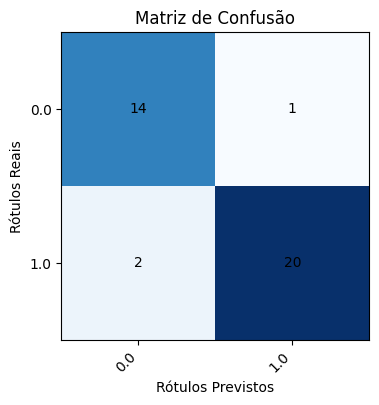

In [15]:
y_predict_mdeep = train_test_mdeep(args={"outcome_type": "binary", "batch_size": 32, "num_epochs": 500, "learning_rate": 1e-4, "dropout_rate": 0.5, "window_size": 128, "kernel_size": (32, 32), "strides": (64, 2), "X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test })

precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_mdeep)
print(f"Epoch: {epoch+1}/{epochs}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_matrix_mdeep = confusion_matrix(y_test, y_predict_mdeep)
ConfusionMatrixDisplay(confusion_matrix_mdeep)

Precision: 0.9545
Recall: 0.9545
Accuracy: 0.9459
F1-Score: 0.9545
F2-Measure: 0.9545
--------------------
indice: [10, 12]


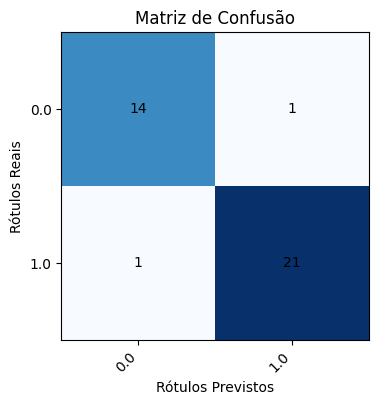

In [16]:
precision, recall, accuracy, f1, f2 = calculate_metrics(true_ouputs.tolist(), ouputs_squeezed.tolist())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_ouputs.tolist(), ouputs_squeezed.tolist())) if true != pred]
print(f"indice: {misclassified_indices}")

confusion_Micronet = confusion_matrix(y_test, ouputs_squeezed.tolist())
ConfusionMatrixDisplay(confusion_Micronet)

Epoch: 10/10
Precision: 0.9474
Recall: 0.8182
Accuracy: 0.8649
F1-Score: 0.8780
F2-Measure: 0.8411
--------------------


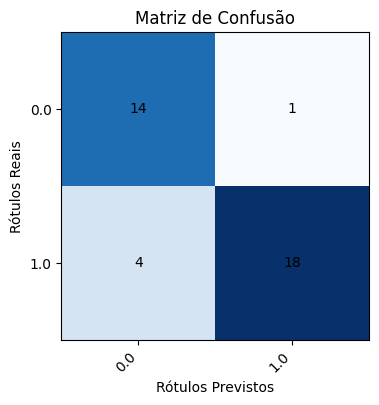

In [17]:
    mlp_pred, clp = Perceptron_Model(X_train, y_train, X_test)
    precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, mlp_pred)


    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Measure: {f2:.4f}")
    print("--------------------")

    confusion_mat_mlp = confusion_matrix(y_test, mlp_pred)
    ConfusionMatrixDisplay(confusion_mat_mlp)

Epoch: 10/10
Precision: 1.0000
Recall: 0.8182
Accuracy: 0.8919
F1-Score: 0.9000
F2-Measure: 0.8491
--------------------


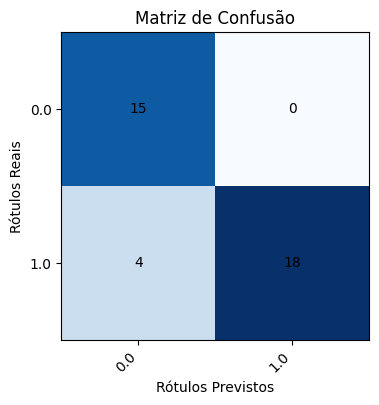

In [18]:
y_predict_dt, clf = Decision_Tree_Model(X_train, y_train, X_test)
precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_dt)


print(f"Epoch: {epoch+1}/{epochs}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_mat_dt = confusion_matrix(y_test, y_predict_dt)
ConfusionMatrixDisplay(confusion_mat_dt)

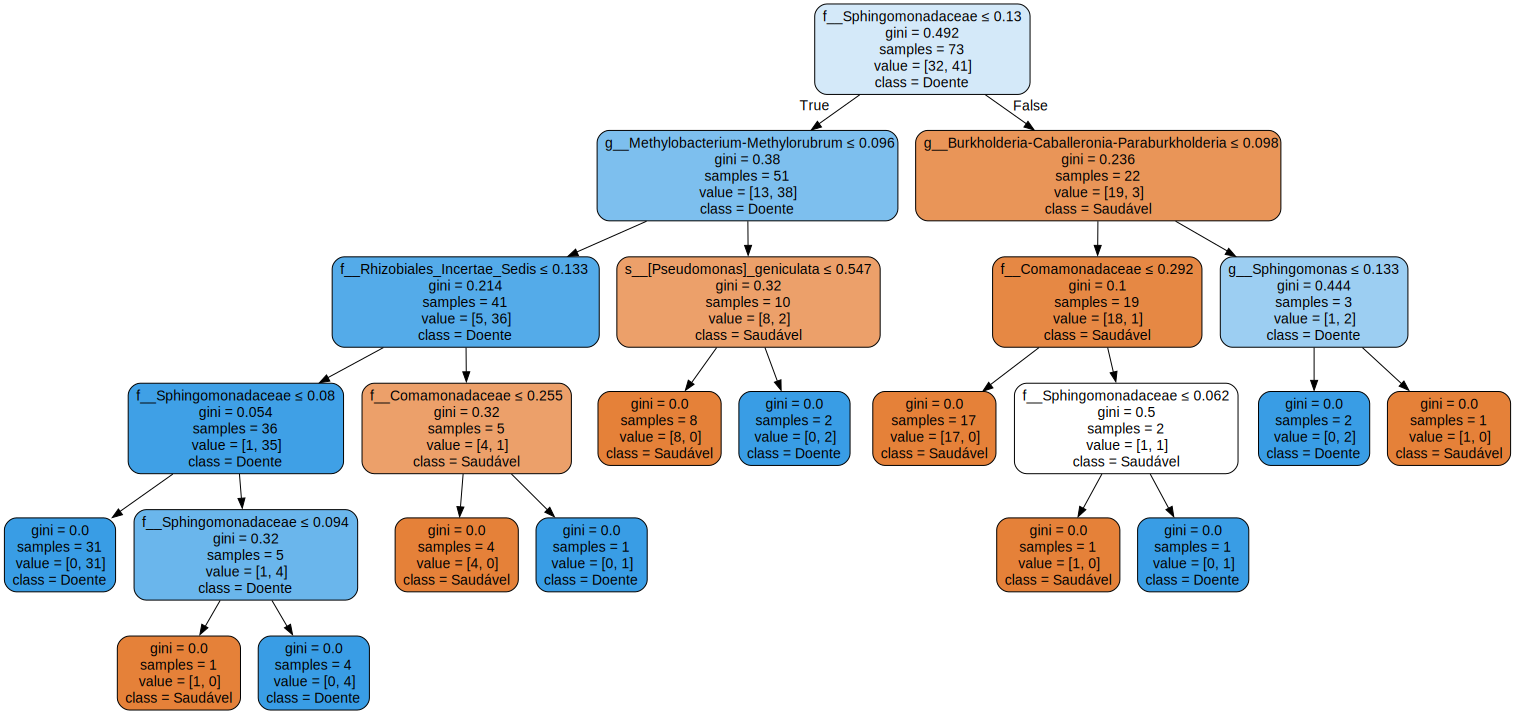

In [19]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf, out_file=None,
                      feature_names=X_train.columns,
                      class_names= ["Doente" if value == 1.0 else "Saudável" for value in clf.classes_],
                      filled=True, rounded=True,
                      special_characters=True)

graph = graphviz.Source(dot_data)
a = pydotplus.graph_from_dot_data(dot_data)
a.write_png('decision_tree.png')
graph

Precision: 1.0000
Recall: 0.8182
Accuracy: 0.8919
F1-Score: 0.9000
F2-Measure: 0.8491
--------------------


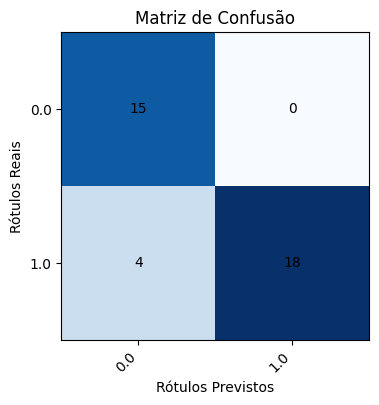

In [20]:
y_predict_rf, clr = Random_Forest_Model(X_train, y_train, X_test)
precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_rf)



print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_mat_rf = confusion_matrix(y_test, y_predict_rf)
ConfusionMatrixDisplay(confusion_mat_rf)

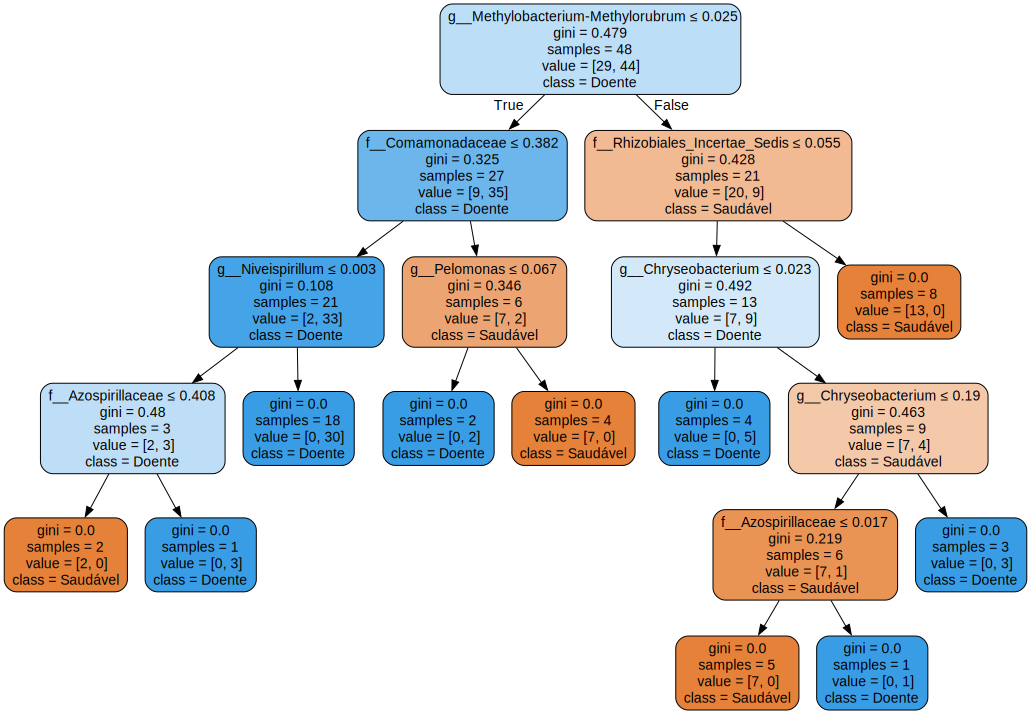

In [21]:


tree = clr.estimators_[0]


dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X_train.columns,
                           class_names=["Doente" if value == 1.0 else "Saudável" for value in clr.classes_],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
a = pydotplus.graph_from_dot_data(dot_data)
a.write_png('random_tree.png')
graph

Epoch: 10/10
Precision: 1.0000
Recall: 0.8182
Accuracy: 0.8919
F1-Score: 0.9000
F2-Measure: 0.8491
--------------------


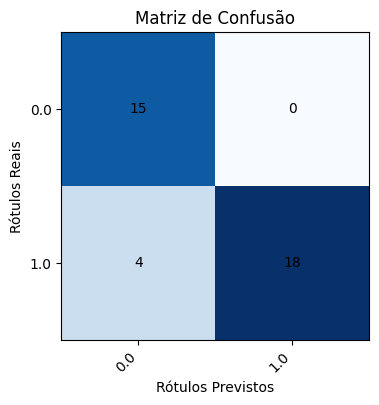

In [22]:
y_predict_svm, cls = SVM_Model(X_train, y_train, X_test)
precision, recall, accuracy, f1, f2 = calculate_metrics(y_test, y_predict_svm)


print(f"Epoch: {epoch+1}/{epochs}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Measure: {f2:.4f}")
print("--------------------")

confusion_mat_svm = confusion_matrix(y_test, y_predict_svm)
ConfusionMatrixDisplay(confusion_mat_svm)

In [23]:
confusion_matrix_mdeep

array([[14,  1],
       [ 2, 20]], dtype=int64)

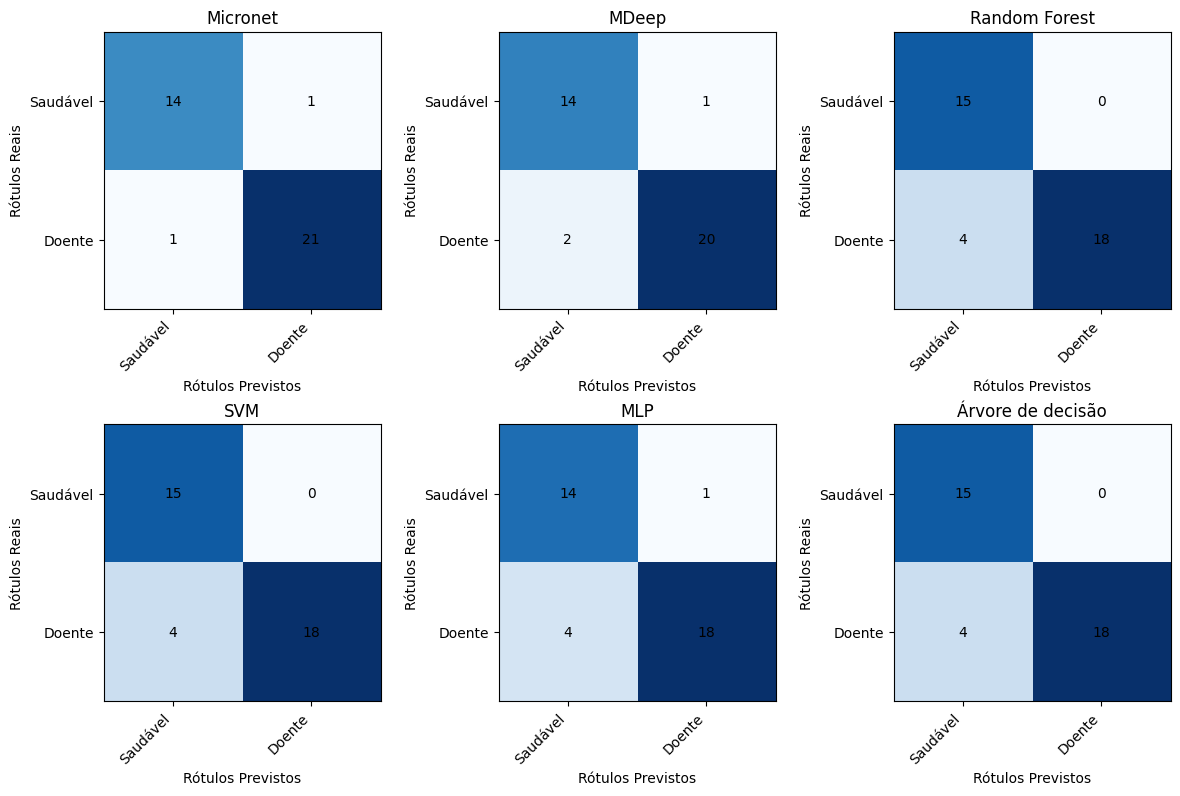

In [24]:

plot_Confusion_Matrices([("Micronet", confusion_Micronet),
                         ("MDeep",confusion_matrix_mdeep),
                         ("Random Forest",confusion_mat_rf),
                         ("SVM",confusion_mat_svm),
                         ("MLP", confusion_mat_mlp),
                        ("Árvore de decisão",confusion_mat_dt),])


In [25]:
def plot_ROC(y_true, y_preds):
    plt.figure(figsize=(8, 6))

    blues = ['#1f77b4', '#98df8a', 'orange', '#2ca02c', '#8c564b', 'red']


    colors = blues
    random_color = 'darkred'

    for i, (name, y_pred) in enumerate(y_preds):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        if name == "SVM":
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})', linestyle='--',  color=colors[i])
        else:
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})', linestyle='-',  color=colors[i])

    plt.plot([0, 1], [0, 1], color=random_color, lw=2, linestyle='--', label='Aleatório')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva Característica de Operação do Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [26]:
mlp_pred.shape

(37,)

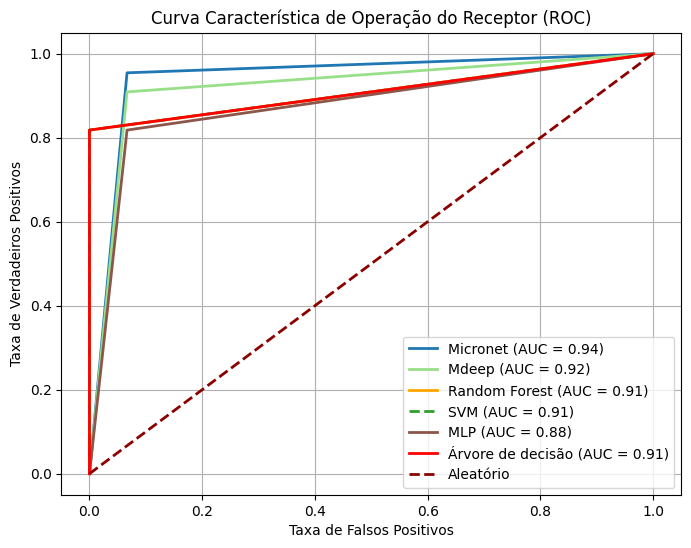

In [27]:
plot_ROC(y_test.values, [("Micronet", ouputs_squeezed.tolist()),
                         ("Mdeep", y_predict_mdeep),
                         ("Random Forest", y_predict_rf),
                         ("SVM", y_predict_svm),
                         ("MLP", mlp_pred),
                         ("Árvore de decisão", y_predict_dt)])

In [28]:

def microNet_predict(input_data):
    input_tensor = torch.FloatTensor(input_data)
    return microNet(input_tensor).detach().numpy()

In [29]:

explainer = shap.KernelExplainer(microNet_predict, X_train)
shap_values = explainer.shap_values(X_train)
rf_explainer = shap.TreeExplainer(clr)
rf_shap_values = rf_explainer.shap_values(X_train)
dt_explainer = shap.TreeExplainer(clf)
dt_shap_values = dt_explainer.shap_values(X_train)
svm_explainer = shap.KernelExplainer(cls.steps[-1][1].predict , X_train)
svm_shap_values = svm_explainer.shap_values(X_train)


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

In [30]:
explainer_mdeep = shap.KernelExplainer(model_predict_mdeep, X_train)
shap_values_mdeep = explainer_mdeep.shap_values(X_train)


  0%|          | 0/73 [00:00<?, ?it/s]

In [31]:

mlp_explainer = shap.KernelExplainer(clp.predict, X_train)
mlp_shap_values = mlp_explainer.shap_values(X_train)

  0%|          | 0/73 [00:00<?, ?it/s]

In [32]:
shap.initjs()

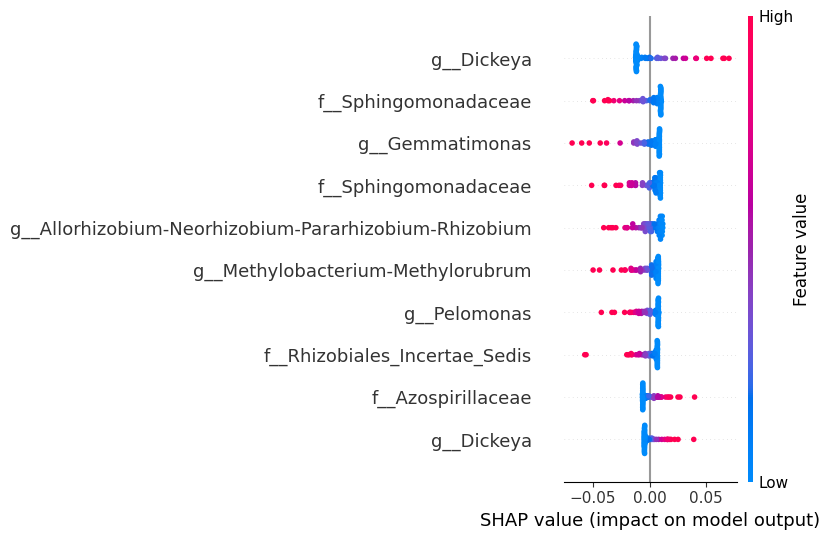

<Figure size 1800x1500 with 0 Axes>

In [33]:
shap.summary_plot(shap_values[0], X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

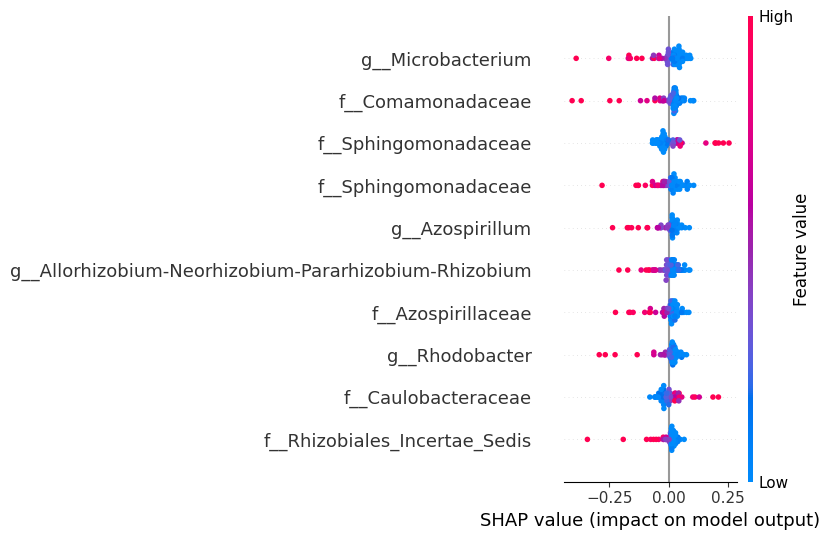

<Figure size 1800x1500 with 0 Axes>

In [34]:

shap.summary_plot(shap_values_mdeep, X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

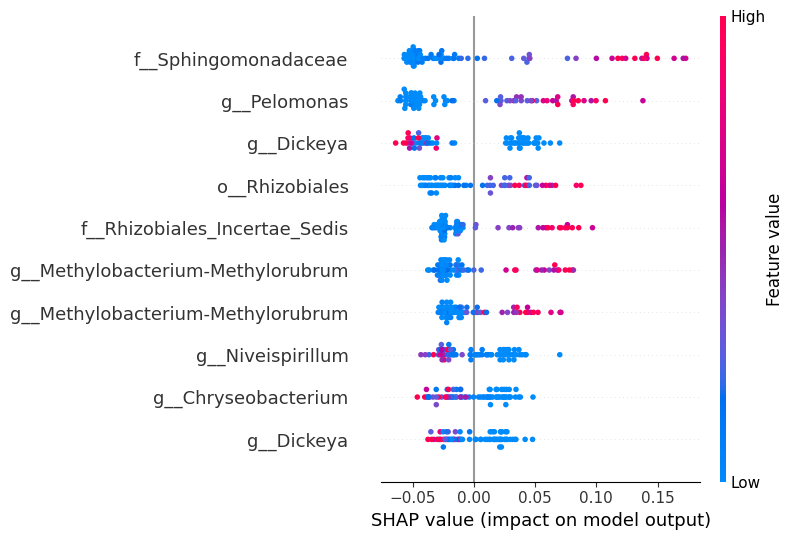

<Figure size 1800x1500 with 0 Axes>

In [35]:
shap.summary_plot(rf_shap_values[0], X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

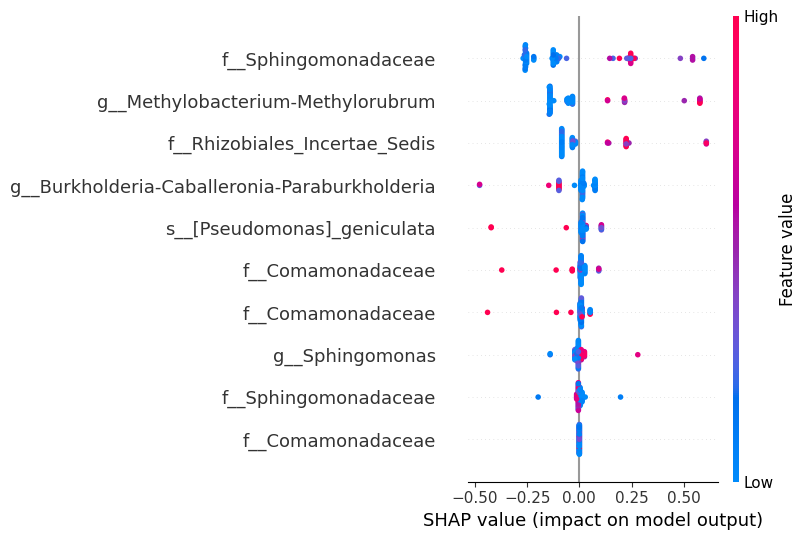

<Figure size 1800x1500 with 0 Axes>

In [36]:
shap.summary_plot(dt_shap_values[0], X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

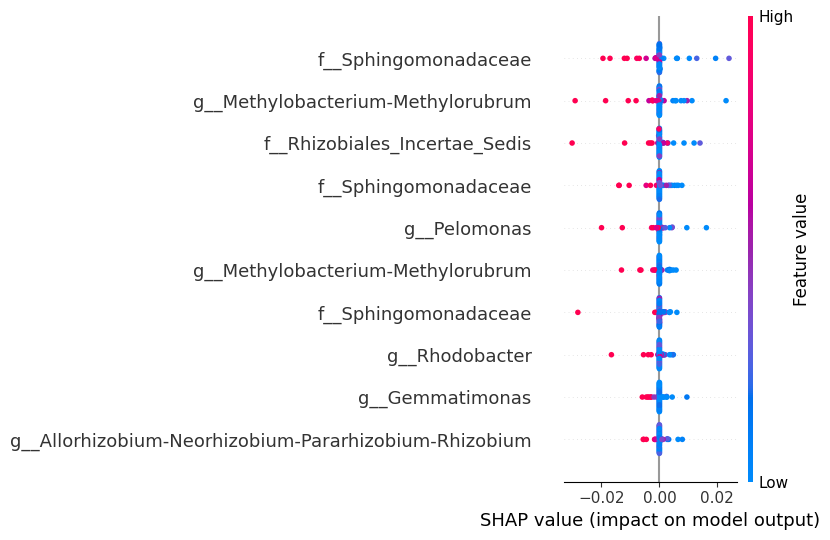

<Figure size 1800x1500 with 0 Axes>

In [37]:
shap.summary_plot(svm_shap_values, X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()

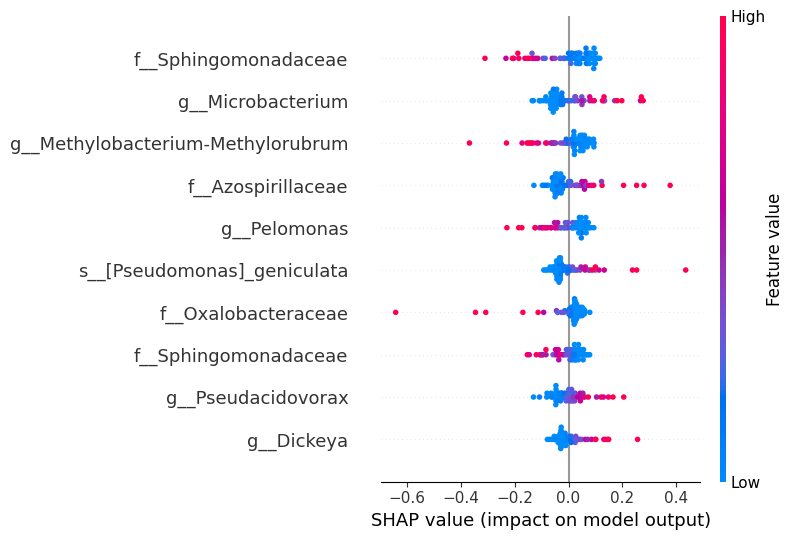

<Figure size 1800x1500 with 0 Axes>

In [38]:
shap.summary_plot(mlp_shap_values, X_train, max_display=10)
plt.figure(figsize=(18, 15))
plt.show()